### Plot Nugent Spectral Series for Type IIP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import pickle
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

from lltypeiip.config import config, SED_COLORS, SED_MARKERS
from lltypeiip.photometry import get_wise_lc_data, get_ztf_lc_data, convert_ZTF_mag_mJy
from lltypeiip.photometry.plotting import plot_combined_lc
from lltypeiip.sed.plotting import plot_sed
from lltypeiip.sed.build import _prepare_sed_xy
from lltypeiip.dusty.runner import DustyRunner
from lltypeiip.dusty.custom_spectrum import NugentIIPSeries

from alerce.core import Alerce

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
typeiip = NugentIIPSeries('/home/cal/analam/Documents/LL_typeIIP/data/typeiip_spectral_templates/sn2p_flux.v1.2.dat')

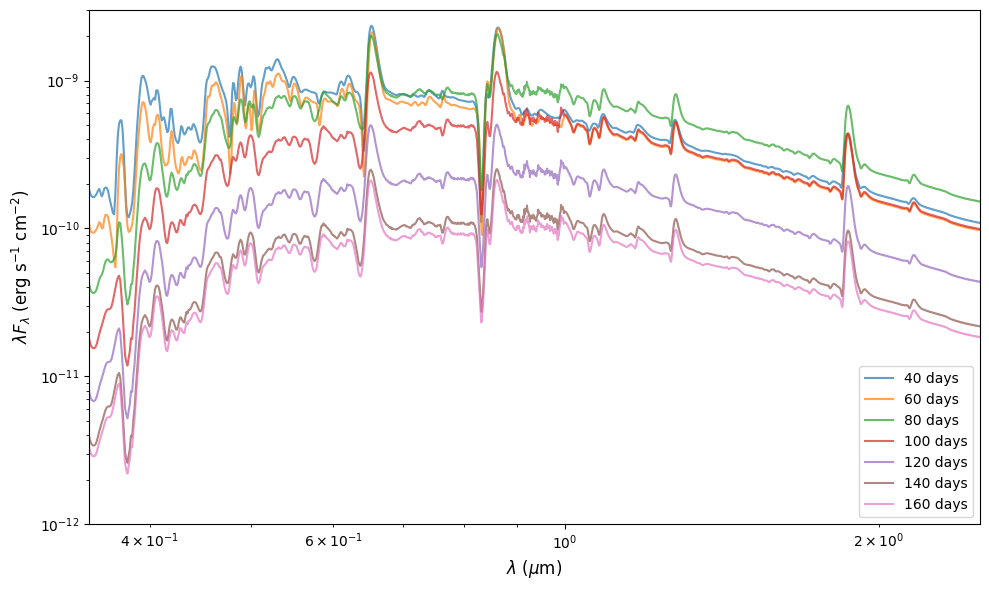

In [4]:
# spectra at different epochs
fig, ax = plt.subplots(figsize=(10, 6))

phases_to_plot = [40, 60, 80, 100, 120, 140, 160] 

for phase in phases_to_plot:
    lam, flux = typeiip.spectrum_at(phase)
    lam_f_lam = lam * flux
    ax.plot(lam, lam_f_lam, label=f'{phase} days', alpha=0.7)

ax.set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=12)
ax.set_ylabel(r"$\lambda F_\lambda$ (erg s$^{-1}$ cm$^{-2}$)", fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-12, 3e-9)
ax.set_xlim(0.35, 2.5)
ax.legend()
plt.tight_layout()
plt.show()

In [5]:
oid = "ZTF19aadnxnl" 

mcmc_dir = Path("/home/cal/analam/Documents/LL_typeIIP/mcmc_results") / oid
sed_pkl_dir = Path("/home/cal/analam/Documents/LL_typeIIP/data/tail_seds")
template_path = Path("/home/cal/analam/Documents/LL_typeIIP/data/typeiip_spectral_templates/sn2p_flux.v1.2.dat")

bb_mcmc_file = mcmc_dir / f"mcmc_{oid}_mixture.npz"
template_mcmc_file = mcmc_dir / f"mcmc_{oid}_template_mixture.npz"

grid_csv = Path("/home/cal/analam/Documents/LL_typeIIP/dusty_runs/template_grids/grid_summary_nugent_iip.csv")

In [6]:
sed_pkl = sed_pkl_dir / f"{oid}_tail_sed.pkl"
with open(sed_pkl, "rb") as f:
    sed_obj = pickle.load(f)
sed = sed_obj.get("sed", sed_obj)

print(f"SED epoch: MJD {sed['mjd']:.2f}")
print(f"Bands: {sed['bands']}")
print(f"Phase: {sed.get('phase_days', 'N/A')} days")

# Load photometry for inset
alerce = Alerce()
ztf_resdict = get_ztf_lc_data(oid, alerce, doLC=False, doStamps=False, add_forced=True)
ztf_resdict = convert_ZTF_mag_mJy(ztf_resdict, forced=True)
wise_resdict = get_wise_lc_data(oid)

SED epoch: MJD 58631.44
Bands: ['ZTF_g', 'ZTF_r', 'ZTF_i', 'W1', 'W2']
Phase: 132.93882078009483 days
Saved ztf_resdict for ZTF19aadnxnl to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce


/home/cal/analam/Documents/LL_typeIIP/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
bb_mcmc = np.load(bb_mcmc_file, allow_pickle=True)
bb_samples = bb_mcmc['samples']  # Shape: (n_walkers * n_steps, 4) for [tstar, tdust, log10_tau, log10_a]
bb_grid_best = bb_mcmc['grid_best'].item()

# Extract parameters from samples (use median as best-fit)
bb_tstar = np.median(bb_samples[:, 0])
bb_tdust = np.median(bb_samples[:, 1])
bb_tau = 10**np.median(bb_samples[:, 2])  # Convert from log10
bb_a = 10**np.median(bb_samples[:, 3])    # Convert from log10

# Compute uncertainties (16th and 84th percentiles = ±1σ)
bb_tstar_err = np.percentile(bb_samples[:, 0], [16, 84])
bb_tdust_err = np.percentile(bb_samples[:, 1], [16, 84])
bb_tau_err = 10**np.percentile(bb_samples[:, 2], [16, 84])
bb_a_err = 10**np.percentile(bb_samples[:, 3], [16, 84])

print("\n=== Blackbody MCMC Results ===")
print(f"T* = {bb_tstar:.0f} +{bb_tstar_err[1]-bb_tstar:.0f} -{bb_tstar-bb_tstar_err[0]:.0f} K")
print(f"Td = {bb_tdust:.0f} +{bb_tdust_err[1]-bb_tdust:.0f} -{bb_tdust-bb_tdust_err[0]:.0f} K")
print(f"τ = {bb_tau:.3f} +{bb_tau_err[1]-bb_tau:.3f} -{bb_tau-bb_tau_err[0]:.3f}")
print(f"a = {bb_a:.2e} +{bb_a_err[1]-bb_a:.2e} -{bb_a-bb_a_err[0]:.2e}")
print(f"Grid best = {bb_grid_best}")

tmpl_mcmc = np.load(template_mcmc_file, allow_pickle=True)
tmpl_samples = tmpl_mcmc['samples']
tmpl_grid_best = tmpl_mcmc['grid_best'].item()

# Extract parameters (template has dummy T*)
# tmpl_tstar = np.median(tmpl_samples[:, 0])  # Dummy
tmpl_tstar = tmpl_mcmc['tstar'][0]
tmpl_tdust = np.median(tmpl_samples[:, 0])
tmpl_tau = 10**np.median(tmpl_samples[:, 1])
tmpl_a = 10**np.median(tmpl_samples[:, 2])

# Uncertainties
tmpl_tdust_err = np.percentile(tmpl_samples[:, 0], [16, 84])
tmpl_tau_err = 10**np.percentile(tmpl_samples[:, 1], [16, 84])
tmpl_a_err = 10**np.percentile(tmpl_samples[:, 2], [16, 84])

print("\n=== Template MCMC Results ===")
print(f"T* = {tmpl_tstar:.0f} K (dummy, not used)")
print(f"Td = {tmpl_tdust:.0f} +{tmpl_tdust_err[1]-tmpl_tdust:.0f} -{tmpl_tdust-tmpl_tdust_err[0]:.0f} K")
print(f"τ = {tmpl_tau:.3f} +{tmpl_tau_err[1]-tmpl_tau:.3f} -{tmpl_tau-tmpl_tau_err[0]:.3f}")
print(f"a = {tmpl_a:.2e} +{tmpl_a_err[1]-tmpl_a:.2e} -{tmpl_a-tmpl_a_err[0]:.2e}")
print(f"Grid best =  {tmpl_grid_best}")


=== Blackbody MCMC Results ===
T* = 7031 +385 -376 K
Td = 365 +17 -15 K
τ = 3.020 +0.239 -0.264
a = 5.17e-12 +7.10e-13 -6.25e-13
Grid best = {'tstar': 6000.0, 'tdust': 450.0, 'log10_tau': np.float64(0.3010299956639812), 'log10_a': np.float64(-11.474774058512665)}

=== Template MCMC Results ===
T* = 6000 K (dummy, not used)
Td = 674 +502 -397 K
τ = 0.002 +0.013 -0.001
a = 2.31e-12 +2.53e-14 -2.48e-14
Grid best =  {'tdust': 600.0, 'log10_tau': np.float64(-3.0), 'log10_a': np.float64(-11.63672278854628)}


In [8]:
runner = DustyRunner(
    base_workdir=config.dusty.workdir,
    dusty_file_dir=config.dusty.dusty_file_dir,
    cache_dir=config.dusty.npz_cache_dir,
    use_tmp=True
)

template_series = NugentIIPSeries(template_path)

phase_days = sed.get("phase_days", None)

print(f"\nGenerating models at phase = {phase_days:.1f} days...")

# Generate Blackbody MCMC model
print("  Generating BB MCMC model...")
lam_bb, lamFlam_bb, r1_bb = runner.evaluate_model(
    tstar=bb_tstar,
    tdust=bb_tdust,
    tau=bb_tau,
    shell_thickness=2.0
)
lamFlam_bb_scaled = lamFlam_bb * bb_a

# Generate Template MCMC model
print("  Generating Template MCMC model...")
lam_tmpl, lamFlam_tmpl, r1_tmpl = runner.evaluate_model(
    tstar=tmpl_tstar,  # Dummy value, not used
    tdust=tmpl_tdust,
    tau=tmpl_tau,
    shell_thickness=2.0,
    template=template_series,
    phase_days=phase_days,
    template_tag="nugent_iip"
)
lamFlam_tmpl_scaled = lamFlam_tmpl * tmpl_a

# Generate Grid best fits (if available)
print("  Generating Grid best models...")

# BB Grid best
lam_bb_grid, lamFlam_bb_grid, r1_bb_grid = runner.evaluate_model(
    tstar=bb_grid_best['tstar'],
    tdust=bb_grid_best['tdust'],
    tau=10**bb_grid_best['log10_tau'],
    shell_thickness=bb_grid_best.get('shell_thickness', 2.0)
)
lamFlam_bb_grid_scaled = lamFlam_bb_grid * 10**bb_grid_best['log10_a']

# Template Grid best
lam_tmpl_grid, lamFlam_tmpl_grid, r1_tmpl_grid = runner.evaluate_model(
    tstar=tmpl_grid_best.get('tstar_dummy', 6000.0),
    tdust=tmpl_grid_best['tdust'],
    tau=10**tmpl_grid_best['log10_tau'],
    shell_thickness=tmpl_grid_best.get('shell_thickness', 2.0),
    template=template_series,
    phase_days=phase_days,
    template_tag="nugent_iip"
)
lamFlam_tmpl_grid_scaled = lamFlam_tmpl_grid * 10**tmpl_grid_best['log10_a']

print("Scale factors:")
print(f"  BB MCMC a = {bb_a:.2e}")
print(f"  Template MCMC a = {tmpl_a:.2e}")


Generating models at phase = 132.9 days...
  Generating BB MCMC model...
  Generating Template MCMC model...
  Generating Grid best models...
Scale factors:
  BB MCMC a = 5.17e-12
  Template MCMC a = 2.31e-12



Nugent template diagnostics:
  Wavelength range: 0.1000 - 2.5000 μm
  λF_λ range (unscaled): 5.97e-18 - 2.96e-10
  λF_λ range (scaled): 4.16e-20 - 2.06e-12
  Current plot xlim: (np.float64(0.19267377123620488), np.float64(11.388161377243517))
  Current plot ylim: (np.float64(4.9793732509343674e-14), np.float64(3.711617337477665e-12))
(np.float64(0.19267377123620488), np.float64(11.388161377243517)) (np.float64(4.9793732509343674e-14), np.float64(3.711617337477665e-12))

Saved comparison plot to /home/cal/analam/Documents/LL_typeIIP/mcmc_results/ZTF19aadnxnl


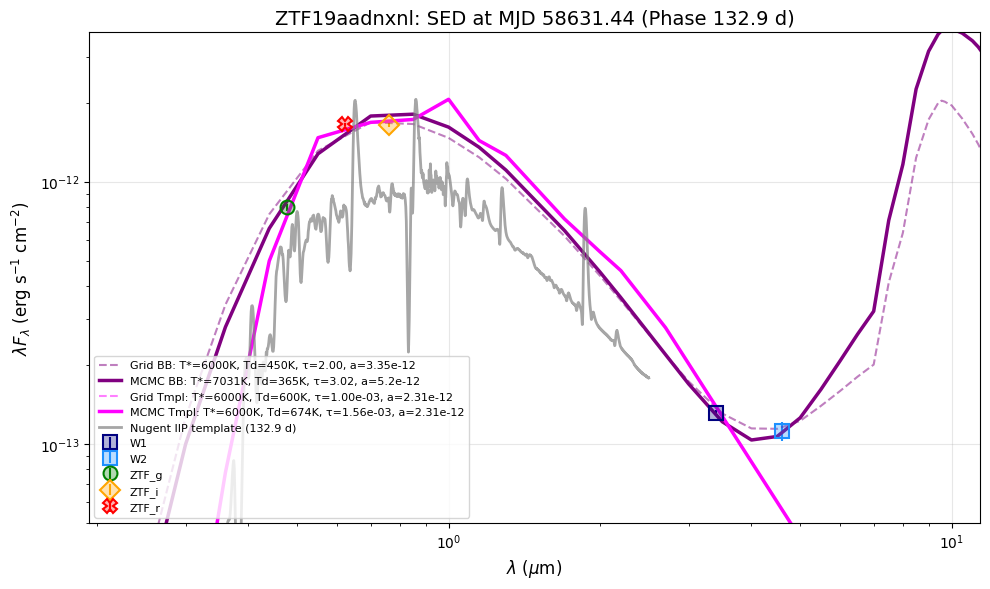

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot observed SED data points
x, y, ey, x_label, y_label = _prepare_sed_xy(sed, y_mode="Flam")
bands = np.array(sed["bands"])
is_ul = np.array(sed["is_ul"])

# Detections
for b in np.unique(bands):
    sel = (bands == b) & (~is_ul)
    if np.any(sel):
        rgba = mcolors.to_rgba(SED_COLORS.get(b, "black"), alpha=0.3)
        ax.errorbar(
            x[sel], y[sel], yerr=ey[sel],
            fmt=SED_MARKERS.get(b, "o"),
            color=SED_COLORS.get(b, "black"),
            mec=SED_COLORS.get(b, "black"),
            mfc=rgba,
            linestyle="none",
            label=b,
            markersize=10,
            markeredgewidth=1.5
        )

# Upper limits
for b in np.unique(bands):
    sel = (bands == b) & (is_ul)
    if np.any(sel):
        ax.errorbar(
            x[sel], y[sel],
            yerr=None,
            uplims=True,
            fmt="v",
            markersize=8,
            color=SED_COLORS.get(b, "black"),
            alpha=0.5,
            linestyle="none"
        )

det_mask = ~is_ul
x_det = x[det_mask]
y_det = y[det_mask]

# Plot models
# BB Grid (thin, light)
ax.plot(lam_bb_grid, lamFlam_bb_grid_scaled,
        color='purple', linestyle='--', linewidth=1.5, alpha=0.5,
        label=f"Grid BB: T*={bb_grid_best['tstar']:.0f}K, "
              f"Td={bb_grid_best['tdust']:.0f}K, τ={10**bb_grid_best['log10_tau']:.2f}, "
              f"a={10**bb_grid_best['log10_a']:.2e}")

# BB MCMC (thick, prominent)
ax.plot(lam_bb, lamFlam_bb_scaled,
        color='purple', linestyle='-', linewidth=2.5,
        label=f"MCMC BB: T*={bb_tstar:.0f}K, "
              f"Td={bb_tdust:.0f}K, τ={bb_tau:.2f}, "
              f"a={bb_a:.2}")

# Template Grid (thin, light)
ax.plot(lam_tmpl_grid, lamFlam_tmpl_grid_scaled,
        color='magenta', linestyle='--', linewidth=1.5, alpha=0.5,
        label=f"Grid Tmpl: T*=6000K, "
              f"Td={tmpl_grid_best['tdust']:.0f}K, "
              f"τ={10**tmpl_grid_best['log10_tau']:.2e}, "
              f"a={10**tmpl_grid_best['log10_a']:.2e}")

# Template MCMC (thick, prominent)
ax.plot(lam_tmpl, lamFlam_tmpl_scaled,
        color='magenta', linestyle='-', linewidth=2.5,
        label=f"MCMC Tmpl: T*=6000K, "
              f"Td={tmpl_tdust:.0f}K, "
              f"τ={tmpl_tau:.2e}, "
              f"a={tmpl_a:.2e}")

if len(x_det) > 0 and len(y_det) > 0:
    # X limits: add margin in log space
    x_min, x_max = x_det.min(), x_det.max()
    x_range = np.log10(x_max) - np.log10(x_min)
    x_margin = 0.4  # 30% margin in log space
    ax.set_xlim(
        10**(np.log10(x_min) - x_margin * x_range),
        10**(np.log10(x_max) + x_margin * x_range)
    )
    
    # Y limits: add margin in log space
    y_min, y_max = y_det.min(), y_det.max()
    y_range = np.log10(y_max) - np.log10(y_min)
    y_margin = 0.3  # 50% margin in log space
    ax.set_ylim(
        10**(np.log10(y_min) - y_margin * y_range),
        10**(np.log10(y_max) + y_margin * y_range)
    )

# plot nugent template spectrum at the same phase for reference
phase = 132.9 
lam, flux = template_series.spectrum_at(phase)
lam_f_lam = lam * flux


# Scale to match the peak of the Template MCMC model
peak_template_raw = np.max(lam_f_lam)
peak_template_model = np.max(lamFlam_tmpl_scaled)
scale_factor = peak_template_model / peak_template_raw

print(f"\nNugent template diagnostics:")
print(f"  Wavelength range: {lam.min():.4f} - {lam.max():.4f} μm")
print(f"  λF_λ range (unscaled): {lam_f_lam.min():.2e} - {lam_f_lam.max():.2e}")
print(f"  λF_λ range (scaled): {(lam_f_lam * scale_factor).min():.2e} - {(lam_f_lam * scale_factor).max():.2e}")
print(f"  Current plot xlim: {ax.get_xlim()}")
print(f"  Current plot ylim: {ax.get_ylim()}")

ax.plot(lam, lam_f_lam * scale_factor, 
        label=f'Nugent IIP template ({phase:.1f} d)', 
        linewidth=2, linestyle='-', color='grey', alpha=0.7)


# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=12)
ax.set_ylabel(r"$\lambda F_\lambda$ (erg s$^{-1}$ cm$^{-2}$)", fontsize=12)
ax.set_title(f"{oid}: SED at MJD {sed['mjd']:.2f} (Phase {phase_days:.1f} d)", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8, loc='lower left')
print(ax.get_xlim(), ax.get_ylim())
plt.tight_layout()
plt.savefig(mcmc_dir / f"{oid}_bb_vs_template_comparison.pdf", dpi=300, bbox_inches='tight')
plt.savefig(mcmc_dir / f"{oid}_bb_vs_template_comparison.png", dpi=300, bbox_inches='tight')
print(f"\nSaved comparison plot to {mcmc_dir}")
plt.show()

In [10]:
print(f"Nugent template wavelength points: {len(lam)}")
print(f"DUSTY output wavelength points: {len(lam_tmpl)}")
print(f"Nugent Δλ (median): {np.median(np.diff(lam)):.4f} μm")
print(f"DUSTY Δλ (median): {np.median(np.diff(lam_tmpl)):.4f} μm")

Nugent template wavelength points: 2401
DUSTY output wavelength points: 105
Nugent Δλ (median): 0.0010 μm
DUSTY Δλ (median): 0.5000 μm
